# Implement VeloVAE in gastrulation erythroid maturation data

To compare with [Gu et al.](https://www.biorxiv.org/content/10.1101/2022.07.08.499381v1.full) in bioRxiv (doi: https://doi.org/10.1101/2022.07.08.499381; version 1), in this notebook, we follow the instructions of [VeloVAE](https://github.com/welch-lab/VeloVAE) and implement DeepVelo in gastrulation erythroid maturation data. The selected cells with genes in gastrulation erythroid maturation data are the same as the datasets used in our study. The input data could be downloaded from [GastrulationErythroid.h5ad](https:DentateGyrus.h5ad).

## Build environment and install dependencies

We create the environment of VeloVAE by running the commands below in an anaconda environment. We download and install VeloVAE from https://github.com/welch-lab/VeloVAE on the main thread on 08/03/2022. The code could also be downloaded [here](https://github.com/welch-lab/VeloVAE). We install cellDancer to plot figures.

`conda create -n velovae python=3.7.6`

`conda activate velovae`

`pip install scvelo`

`pip install loess`

`pip install 'your_path/Source Code/cellDancer'`

`pip install -r 'your_path/Source Code/cellDancer/requirements.txt'`

# Import packages

In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import pandas as pd
import os.path
sys.path.append('../')
import velovae as vv
import celldancer as cd

# Load gastrulation erythroid maturation data

In [2]:
dataset = "Gastrulation"
adata = scv.read("your_path/GastrulationErythroid.h5ad")

# Run VeloVAE

We run VeloVAE with the same configurations in the instruction. 

In [3]:
# Set the parent folder names for saving model parameters, data and figures.
model_path_base = f"checkpoints/{dataset}"
figure_path_base = f"figures/{dataset}"
data_path_base = f"data/{dataset}"

In [4]:
os.makedirs(figure_path_base, exist_ok=True)

In [5]:
figure_path = figure_path_base+"/VAE"
model_path = model_path_base+"/VAE"
data_path = data_path_base

In [6]:
torch.manual_seed(2022)
np.random.seed(2022)
vae = vv.VAE(adata, tmax=20, dim_z=5, device='cpu')
vae.train(adata, plot=False, figure_path=figure_path, embed="umap")
vae.save_model(model_path, 'encoder_vae', 'decoder_vae')
vae.save_anndata(adata, 'vae', data_path, file_name=f"{dataset}_out.h5ad")

Initialization using the steady-state and dynamical models.
Gaussian Prior.
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 68, test iteration: 134
*********       Stage 1: Early Stop Triggered at epoch 249.       *********
*********                      Stage  2                       *********
Cell-wise KNN Estimation.
Percentage of Invalid Sets: 0.011
Average Set Size: 238
Finished. Actual Time:   0 h :  0 m : 11 s
*********       Stage 2: Early Stop Triggered at epoch 391.       *********
*********

# Visualize the phase portraits of sample genes

Model vae using all genes:
computing velocity graph (using 12/48 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:01:24) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:04) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)


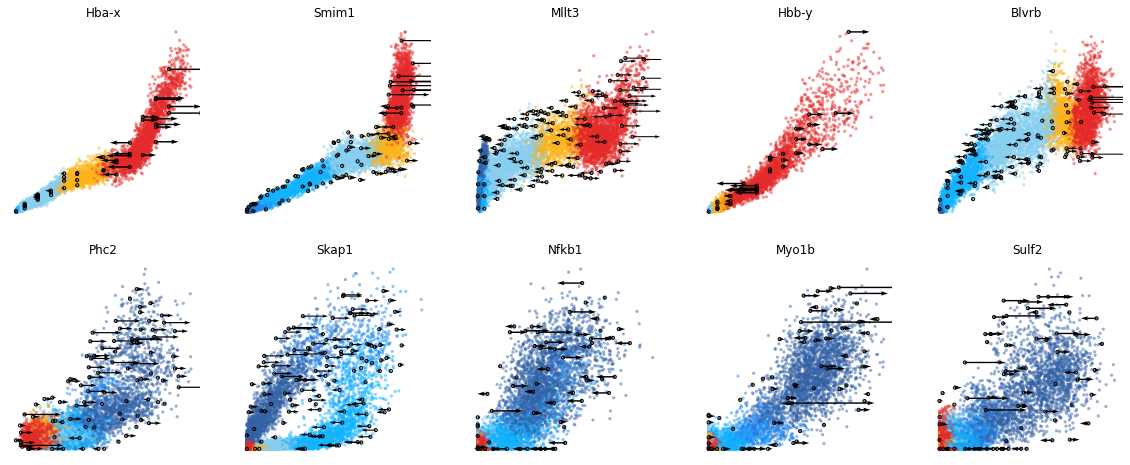

In [7]:
import matplotlib.pylab as plt
import math
from adata_to_df import adata_to_df

figure_path_base = f"figures/{dataset}"
data_path_base = f"data/{dataset}"

adata.var['velocity_genes']=True
basis = "umap"
gene_list = ['Hba-x','Smim1','Mllt3','Hbb-y','Blvrb','Phc2','Skap1','Nfkb1','Myo1b','Sulf2']

for key in ['vae']:
    print(f"Model {key} using all genes:")
    scv.tl.velocity_graph(adata, vkey=f'{key}_velocity', n_jobs=12)
    scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity', basis=basis)
    
    # transfer anndata to pandas dataframe
    # Note that VeloVADE does not have the feature to calculate du/dt, we set it to 0.
    df = adata_to_df(adata, \
        us_para=['Mu', 'Ms'], us_pred_para=[f'{key}_velocity_u', f'{key}_velocity'], \
        cell_type_para='clusters', embed_para=f'X_{basis}', \
        embed_pred_para=f'{key}_velocity_{basis}')

    ncols=5
    height=math.ceil(len(gene_list)/5)*4
    fig = plt.figure(figsize=(20, height))

    for i in range(len(gene_list)):
        ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
        cd.cdplt.scatter_gene(
            ax=ax,
            x='splice',
            y='unsplice',
            cellDancer_df=df,
            custom_xlim=None,
            custom_ylim=None,
            colors=cd.cdplt.colormap.colormap_erythroid,
            alpha=0.5,
            s = 10,
            velocity=True,
            gene=gene_list[i])

        ax.set_title(gene_list[i])
        ax.axis('off')
    plt.savefig(figure_path_base+f"/gene_velocity_all_genes_{key}.pdf")
    plt.show()

# Project the RNA velocity to vector fields in the embedding space for transcriptional boost genes

To have a fair comparison between our method and VeloVAE, we also implement DeepVelo to datasets with MURK genes only and project the RNA velocity in embedding space. The MURK gene list could be obtained from [Additional file 3: Table S2](https://static-content.springer.com/esm/art%3A10.1186%2Fs13059-021-02414-y/MediaObjects/13059_2021_2414_MOESM3_ESM.csv) in the work of [Barile et al](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02414-y). 

In [8]:
dataset = "Gastrulation"
adata = scv.read("your_path/GastrulationErythroid.h5ad")
# murk genes
murk_genes=pd.read_csv('your_path/13059_2021_2414_MOESM3_ESM.csv')['index']
adata_murk=adata[:,adata.var_names.isin(murk_genes)]

In [9]:
model_path_base = f"checkpoints/{dataset}_murk"
figure_path_base = f"figures/{dataset}_murk"
data_path_base = f"data/{dataset}_murk"

## Run VeloVAE

In [10]:
figure_path = figure_path_base+"/VAE"
model_path = model_path_base+"/VAE"
data_path = data_path_base
torch.manual_seed(2022)
np.random.seed(2022)
vae = vv.VAE(adata_murk, tmax=20, dim_z=5, device='cpu')
vae.train(adata_murk, plot=False, figure_path=figure_path, embed="umap")
vae.save_model(model_path, 'encoder_vae', 'decoder_vae')
vae.save_anndata(adata_murk, 'vae', data_path, file_name=f"{dataset}_murk_out.h5ad")

## Plot velocity in embedding space

Model vae using all genes:
computing velocity graph (using 12/48 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:00:41) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)


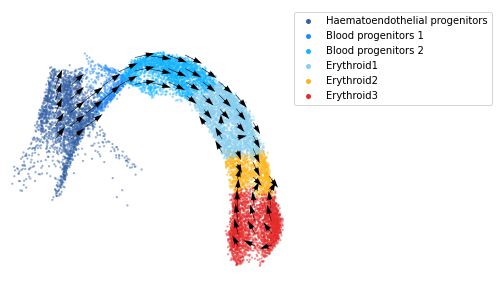

In [11]:
figure_path_base = f"figures/{dataset}_murk"
data_path_base = f"data/{dataset}_murk"

adata_murk.var['velocity_genes']=True

basis = "umap"

for key in ['vae']:
    print(f"Model {key} using all genes:")
    scv.tl.velocity_graph(adata_murk, vkey=f'{key}_velocity', n_jobs=12)
    scv.tl.velocity_embedding(adata_murk, vkey=f'{key}_velocity', basis=basis)
    adata_murk.write_h5ad(data_path_base+f"/{dataset}_murk_out.h5ad")

    # transfer anndata to pandas dataframe
    # Note that VeloVADE does not have the feature to calculate du/dt, we set it to 0.
    df = adata_to_df(adata_murk, \
        us_para=['Mu', 'Ms'], us_pred_para=[f'{key}_velocity_u', f'{key}_velocity'], \
        cell_type_para='clusters', embed_para=f'X_{basis}', \
        embed_pred_para=f'{key}_velocity_{basis}')

    # plot cell velocity
    fig, ax = plt.subplots(figsize=(5,5))
    cd.cdplt.scatter_cell(ax,
                    df,
                    colors=cd.cdplt.colormap.colormap_erythroid,
                    alpha=0.5,
                    s=5,
                    velocity=True,
                    legend='on',
                    min_mass=200,
                    arrow_grid=(20,40),
                    custom_xlim=[-5,11],
                    custom_ylim=[4,18])

    ax.axis('off')
    plt.savefig(figure_path_base+f"/cell_velocity_murk_genes_{key}_{basis}.pdf")

    plt.show()